In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


torch.backends.cudnn.enabled = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2
%matplotlib inline
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

In [2]:
import copy
import time
import torch.nn.functional as F
import torch

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, device, epochs=20):
    start = time.time()
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(epochs):
        print("EPOCH {} / {}: ".format(epoch+1, epochs))
        print("-" * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            batch_loss = 0.0
            batch_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase =='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    #preds = torch.sigmoid(outputs)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                batch_loss += loss.item() * inputs.size(0)
                batch_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = batch_loss / dataset_sizes[phase]
        epoch_acc = batch_corrects.double() / dataset_sizes[phase]
        
        print("{} Loss: {:.4f} Acc: {: .4f}".format(phase, epoch_loss, epoch_acc))
        
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_weights = copy.deepcopy(model.state_dict())
            
    end = time.time()
    elapsed_time = end - start
    print("Training COMPLETED: {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("BEST VALIDATION ACCURACY: {:4f}".format(best_acc))
    
    model.load_state_dict(best_model_weights)
    return model

In [4]:
import pandas as pd
X_train_oversample = pd.read_csv('X_train_oversample.csv', index_col = 'Unnamed: 0')
X_test_oversample = pd.read_csv('X_test_oversample.csv', index_col = 'Unnamed: 0')
y_train_oversample = pd.read_csv('y_train_oversample.csv', index_col = 'Unnamed: 0')
y_test_oversample = pd.read_csv('y_test_oversample.csv', index_col = 'Unnamed: 0')

In [5]:
X_train_oversample

,Килип1,ИндНор1,Creatin,Тромболит3,Килип4,ФУ1,ГБ6,АКШ,Возраст,Килип3,Рла1,Килип2,Кл.вар.ИМ1,Хр.оч.инф2,Pсрлао(Адср)1,ПИ
288,1.0,-0.260822,-0.165048,0.0,0.0,0.117626,0.0,0.0,-0.789860,0.0,-0.088020,0.0,1.0,1.0,0.103881,0.040012
104,0.0,-0.571467,-0.165048,0.0,0.0,-0.730974,0.0,0.0,-0.172457,0.0,-0.092465,1.0,1.0,0.0,0.192557,0.040012
236,0.0,0.687757,-0.165048,0.0,0.0,0.146813,0.0,0.0,0.522121,1.0,0.481789,0.0,0.0,0.0,0.192557,0.020966
1545,0.0,0.581559,0.376523,0.0,0.0,0.505264,0.0,0.0,0.804804,1.0,-0.499022,0.0,0.0,0.0,-1.090116,1.811555
623,0.0,1.081611,-0.286824,0.0,1.0,-1.672989,0.0,0.0,-0.172457,0.0,1.064745,0.0,1.0,0.0,0.192557,0.040012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,1.0,-0.260822,-0.165048,0.0,0.0,-0.388423,0.0,0.0,-0.172457,0.0,-0.660211,0.0,1.0,0.0,0.500996,0.040012
905,0.0,3.860780,1.165575,0.0,1.0,-1.458895,1.0,0.0,0.753647,0.0,-1.017734,0.0,0.0,0.0,-4.125589,-0.282568
1096,0.0,3.531296,1.165575,0.0,1.0,-1.565942,1.0,0.0,1.515606,0.0,-1.432923,0.0,0.0,0.0,-3.598476,-0.282568
235,0.0,-0.227538,-0.286824,0.0,0.0,0.146813,0.0,0.0,-0.095282,0.0,-0.914522,1.0,0.0,0.0,-0.115882,0.953249


In [6]:
X_train_oversample = np.array(X_train_oversample)
X_test_oversample = np.array(X_test_oversample)
y_train_oversample = np.array(y_train_oversample).reshape(-1)
y_test_oversample = np.array(y_test_oversample).reshape(-1)

In [7]:
print(X_train_oversample.shape)
print(X_test_oversample.shape)
print(y_train_oversample.shape)
print(y_test_oversample.shape)

(1425, 16)
(357, 16)
(1425,)
(357,)


In [8]:
import torch.nn as nn
from torchvision import models

model_res = models.resnet18(pretrained = True)
num_features = model_res.fc.in_features
model_res.fc = nn.Linear(num_features, 2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [12]:
def data_to_image(data):
    data_images = []
    font = ImageFont.truetype("arial.ttf", size=20)
    for dat in data:
        background = np.array([[0 for _ in range(255)] for _ in range(255)], dtype='uint8')
        image = Image.fromarray(background)
        draw = ImageDraw.Draw(image) 
        draw.text((70, 10), str(int(dat[0])), fill='white', font=font)
        draw.text((70, 40), str(round(dat[1], 2)), fill='white', font=font)
        draw.text((70, 70), str(round(dat[2], 2)), fill='white', font=font)
        draw.text((70, 100), str(int(dat[3])), fill='white', font=font)
        draw.text((70, 130), str(int(dat[4])), fill='white', font=font)
        draw.text((70, 160), str(round(dat[5], 2)), fill='white', font=font)
        draw.text((70, 190), str(int(dat[6])), fill='white', font=font)
        draw.text((70, 220), str(int(dat[7])), fill='white', font=font)
        draw.text((170, 10), str(round(dat[8], 2)), fill='white', font=font)
        draw.text((170, 40), str(int(dat[9])), fill='white', font=font)
        draw.text((170, 70), str(round(dat[10], 2)), fill='white', font=font)
        draw.text((170, 100), str(int(dat[11])), fill='white', font=font)
        draw.text((170, 130), str(int(dat[12])), fill='white', font=font)
        draw.text((170, 160), str(int(dat[13])), fill='white', font=font)
        draw.text((170, 190), str(round(dat[14], 2)), fill='white', font=font)
        draw.text((170, 220), str(round(dat[15], 2)), fill='white', font=font)
        rgb = [np.array(image, dtype='uint8') for _ in range(3)]
        data_images.append(rgb)
    return np.array(data_images) / 255

(1425, 3, 255, 255)
(357, 3, 255, 255)


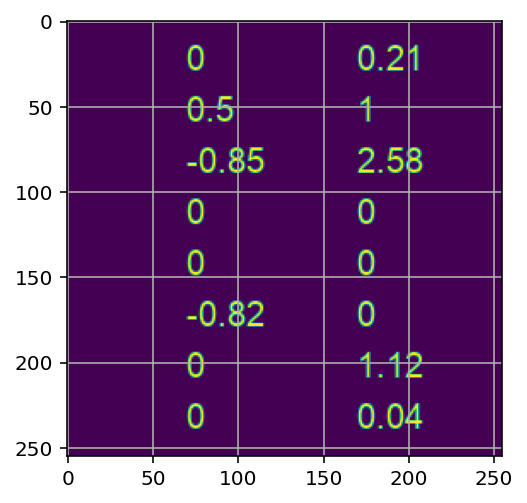

In [13]:
from PIL import Image, ImageDraw, ImageFont

train_images_over = data_to_image(X_train_oversample)
val_images_over = data_to_image(X_test_oversample)

print(train_images_over.shape)
print(val_images_over.shape)
plt.grid()
plt.imshow(train_images_over[9][0, :, :])

In [14]:
X_train_over = torch.from_numpy(train_images_over).float()
y_train_over = torch.from_numpy(y_train_oversample).long()
X_val_over = torch.from_numpy(val_images_over).float()
y_val_over = torch.from_numpy(y_test_oversample).long()

train_dataset_over = TensorDataset(X_train_over, y_train_over)
val_dataset_over = TensorDataset(X_val_over, y_val_over)

dataloaders_over = {'train': DataLoader(train_dataset_over, batch_size=16, shuffle=False),
              'val': DataLoader(val_dataset_over)}

dataset_sizes_over = {'train': len(X_train_over),
                'val': len(X_val_over)}

In [15]:
print(X_train_over.shape)
print(X_val_over.shape)
print(y_train_over.shape)
print(y_val_over.shape)

torch.Size([1425, 3, 255, 255])
torch.Size([357, 3, 255, 255])
torch.Size([1425])
torch.Size([357])


In [16]:
model_over = model_res.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_over.parameters())

In [17]:
best_model_over = train_model(model_over, dataloaders_over, dataset_sizes_over, criterion, optimizer, device, epochs = 10)

EPOCH 1 / 10: 
----------
val Loss: 0.1755 Acc:  0.9272
EPOCH 2 / 10: 
----------
val Loss: 0.1113 Acc:  0.9524
EPOCH 3 / 10: 
----------
val Loss: 0.1230 Acc:  0.9636
EPOCH 4 / 10: 
----------
val Loss: 0.2078 Acc:  0.9272
EPOCH 5 / 10: 
----------
val Loss: 0.1181 Acc:  0.9664
EPOCH 6 / 10: 
----------
val Loss: 0.0776 Acc:  0.9748
EPOCH 7 / 10: 
----------
val Loss: 0.0829 Acc:  0.9720
EPOCH 8 / 10: 
----------
val Loss: 0.0974 Acc:  0.9608
EPOCH 9 / 10: 
----------
val Loss: 0.1698 Acc:  0.9524
EPOCH 10 / 10: 
----------
val Loss: 0.1748 Acc:  0.9580
Training COMPLETED: 6m 23s
BEST VALIDATION ACCURACY: 0.974790


In [18]:
X_val = pd.read_csv('X_val.csv', index_col = 'Unnamed: 0')
y_val = pd.read_csv('y_val.csv', index_col = 'Unnamed: 0')

In [19]:
y_pred_val_over = []
X_val = np.array(X_val)
y_val = np.array(y_val).reshape(-1)

X_val_img = data_to_image(X_val)

X_val = torch.from_numpy(X_val_img).float()
y_val = torch.from_numpy(y_val).long()

val_dataset = TensorDataset(X_val, y_val)

dataloaders = {'val': DataLoader(val_dataset)}

dataset_sizes_over = {'val': len(X_val)}

for inputs, labels in dataloaders['val']:
  inputs = inputs.to(device)
  outputs = best_model_over(inputs)          
  _, preds = torch.max(outputs, 1)
  y_pred_val_over.append(preds)

In [20]:
preds = list(map(int, np.array(y_pred_val_over)))

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print(accuracy_score(preds, y_val))
print(f1_score(preds, y_val))

0.95
0.9500000000000001


In [22]:
import pandas as pd
X_train_undersample = pd.read_csv('X_train_undersample.csv', index_col = 'Unnamed: 0')
X_test_undersample = pd.read_csv('X_test_undersample.csv', index_col = 'Unnamed: 0')
y_train_undersample = pd.read_csv('y_train_undersample.csv', index_col = 'Unnamed: 0')
y_test_undersample = pd.read_csv('y_test_undersample.csv', index_col = 'Unnamed: 0')

In [23]:
X_train_undersample = np.array(X_train_undersample)
X_test_undersample = np.array(X_test_undersample)
y_train_undersample = np.array(y_train_undersample).reshape(-1)
y_test_undersample = np.array(y_test_undersample).reshape(-1)

In [24]:
print(X_train_undersample.shape)
print(X_test_undersample.shape)
print(y_train_undersample.shape)
print(y_test_undersample.shape)

(174, 16)
(44, 16)
(174,)
(44,)


(174, 3, 255, 255)
(44, 3, 255, 255)


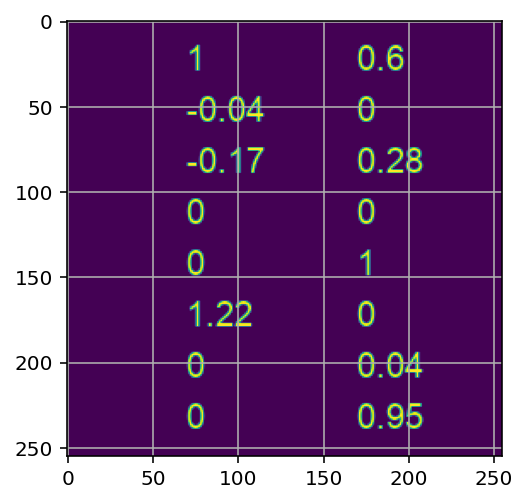

In [25]:
from PIL import Image, ImageDraw, ImageFont

train_images_under = data_to_image(X_train_undersample)
val_images_under = data_to_image(X_test_undersample)

print(train_images_under.shape)
print(val_images_under.shape)
plt.grid()
plt.imshow(train_images_under[9][0, :, :])

In [26]:
X_train_under = torch.from_numpy(train_images_under).float()
y_train_under = torch.from_numpy(y_train_undersample).long()
X_val_under = torch.from_numpy(val_images_under).float()
y_val_under = torch.from_numpy(y_test_undersample).long()

train_dataset_under = TensorDataset(X_train_under, y_train_under)
val_dataset_under = TensorDataset(X_val_under, y_val_under)

dataloaders_under = {'train': DataLoader(train_dataset_under, batch_size=16, shuffle=False),
              'val': DataLoader(val_dataset_under)}

dataset_sizes_under = {'train': len(X_train_under),
                'val': len(X_val_under)}

In [27]:
print(X_train_under.shape)
print(X_val_under.shape)
print(y_train_under.shape)
print(y_val_under.shape)

torch.Size([174, 3, 255, 255])
torch.Size([44, 3, 255, 255])
torch.Size([174])
torch.Size([44])


In [28]:
model_under = model_res.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_under.parameters())

In [29]:
best_model_under = train_model(model_under, dataloaders_under, dataset_sizes_under, criterion, optimizer, device, epochs = 10)

EPOCH 1 / 10: 
----------
val Loss: 3.2859 Acc:  0.6591
EPOCH 2 / 10: 
----------
val Loss: 0.2434 Acc:  0.9318
EPOCH 3 / 10: 
----------
val Loss: 0.3223 Acc:  0.8636
EPOCH 4 / 10: 
----------
val Loss: 0.2887 Acc:  0.8864
EPOCH 5 / 10: 
----------
val Loss: 0.2544 Acc:  0.9318
EPOCH 6 / 10: 
----------
val Loss: 0.2589 Acc:  0.9318
EPOCH 7 / 10: 
----------
val Loss: 0.2903 Acc:  0.9091
EPOCH 8 / 10: 
----------
val Loss: 0.3162 Acc:  0.9091
EPOCH 9 / 10: 
----------
val Loss: 0.3341 Acc:  0.9091
EPOCH 10 / 10: 
----------
val Loss: 0.3478 Acc:  0.9091
Training COMPLETED: 0m 47s
BEST VALIDATION ACCURACY: 0.931818


In [30]:
X_val = pd.read_csv('X_val.csv', index_col = 'Unnamed: 0')
y_val = pd.read_csv('y_val.csv', index_col = 'Unnamed: 0')

In [31]:
y_pred_val_under = []
X_val = np.array(X_val)
y_val = np.array(y_val).reshape(-1)

X_val_img = data_to_image(X_val)

X_val = torch.from_numpy(X_val_img).float()
y_val = torch.from_numpy(y_val).long()

val_dataset = TensorDataset(X_val, y_val)

dataloaders = {'val': DataLoader(val_dataset)}

dataset_sizes_under = {'val': len(X_val)}

for inputs, labels in dataloaders['val']:
  inputs = inputs.to(device)
  outputs = best_model_under(inputs)          
  _, preds = torch.max(outputs, 1)
  y_pred_val_under.append(preds)

In [32]:
preds = list(map(int, np.array(y_pred_val_under)))

In [33]:
print(accuracy_score(preds, y_val))
print(f1_score(preds, y_val))

0.9
0.9


In [47]:
X_train_nothing_changed = pd.read_csv('X_train_nothing.csv', index_col = 'Unnamed: 0')
X_test_nothing_changed = pd.read_csv('X_test_nothing.csv', index_col = 'Unnamed: 0')
y_train_nothing_changed = pd.read_csv('y_train_nothing.csv', index_col = 'Unnamed: 0')
y_test_nothing_changed = pd.read_csv('y_test_nothing.csv', index_col = 'Unnamed: 0')

In [48]:
X_train_nothing_changed = np.array(X_train_nothing_changed)
X_test_nothing_changed = np.array(X_test_nothing_changed)
y_train_nothing_changed = np.array(y_train_nothing_changed).reshape(-1)
y_test_nothing_changed = np.array(y_test_nothing_changed).reshape(-1)

(800, 3, 255, 255)
(200, 3, 255, 255)


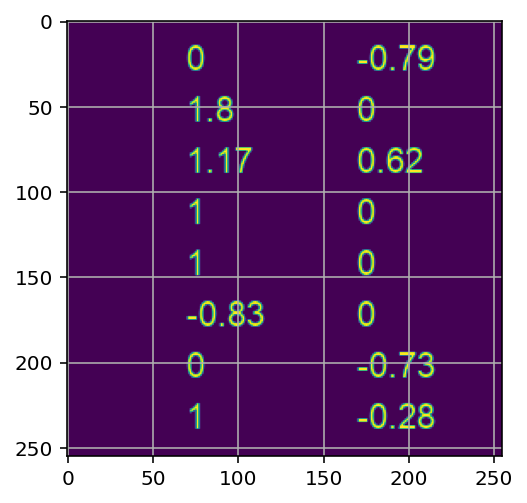

In [49]:
from PIL import Image, ImageDraw, ImageFont

train_images_nothing = data_to_image(X_train_nothing_changed)
val_images_nothing = data_to_image(X_test_nothing_changed)

print(train_images_nothing.shape)
print(val_images_nothing.shape)
plt.grid()
plt.imshow(train_images_nothing[9][0, :, :])

In [50]:
X_train_nothing = torch.from_numpy(train_images_nothing).float()
y_train_nothing = torch.from_numpy(y_train_nothing_changed).long()
X_val_nothing = torch.from_numpy(val_images_nothing).float()
y_val_nothing = torch.from_numpy(y_test_nothing_changed).long()

train_dataset_nothing = TensorDataset(X_train_nothing, y_train_nothing)
val_dataset_nothing = TensorDataset(X_val_nothing, y_val_nothing)

dataloaders_nothing = {'train': DataLoader(train_dataset_nothing, batch_size=16, shuffle=False),
              'val': DataLoader(val_dataset_nothing)}

dataset_sizes_nothing = {'train': len(X_train_nothing),
                'val': len(X_val_nothing)}

In [51]:
print(X_train_nothing.shape)
print(X_val_nothing.shape)
print(y_train_nothing.shape)
print(y_val_nothing.shape)

torch.Size([800, 3, 255, 255])
torch.Size([200, 3, 255, 255])
torch.Size([800])
torch.Size([200])


In [52]:
model_nothing = model_res.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_nothing.parameters())

In [53]:
best_model_nothing = train_model(model_nothing, dataloaders_nothing, dataset_sizes_nothing, criterion, optimizer, device, epochs = 10)

EPOCH 1 / 10: 
----------
val Loss: 0.7932 Acc:  0.8050
EPOCH 2 / 10: 
----------
val Loss: 0.1243 Acc:  0.9650
EPOCH 3 / 10: 
----------
val Loss: 0.1920 Acc:  0.9350
EPOCH 4 / 10: 
----------
val Loss: 0.1406 Acc:  0.9500
EPOCH 5 / 10: 
----------
val Loss: 0.1496 Acc:  0.9700
EPOCH 6 / 10: 
----------
val Loss: 0.2007 Acc:  0.9400
EPOCH 7 / 10: 
----------
val Loss: 0.2424 Acc:  0.9600
EPOCH 8 / 10: 
----------
val Loss: 0.1679 Acc:  0.9600
EPOCH 9 / 10: 
----------
val Loss: 0.2047 Acc:  0.9550
EPOCH 10 / 10: 
----------
val Loss: 0.4658 Acc:  0.9100
Training COMPLETED: 3m 34s
BEST VALIDATION ACCURACY: 0.970000


In [54]:
X_val = pd.read_csv('X_val.csv', index_col = 'Unnamed: 0')
y_val = pd.read_csv('y_val.csv', index_col = 'Unnamed: 0')

In [55]:
y_pred_val_nothing = []
X_val = np.array(X_val)
y_val = np.array(y_val).reshape(-1)

X_val_img = data_to_image(X_val)

X_val = torch.from_numpy(X_val_img).float()
y_val = torch.from_numpy(y_val).long()

val_dataset = TensorDataset(X_val, y_val)

dataloaders = {'val': DataLoader(val_dataset)}

dataset_sizes_nothing = {'val': len(X_val)}

for inputs, labels in dataloaders['val']:
  inputs = inputs.to(device)
  outputs = best_model_nothing(inputs)          
  _, preds = torch.max(outputs, 1)
  y_pred_val_nothing.append(preds)

In [56]:
preds = list(map(int, np.array(y_pred_val_nothing)))

In [57]:
print(accuracy_score(preds, y_val))
print(f1_score(preds, y_val))

0.925
0.9230769230769231
